In [ ]:
import json
import random

queries = []  # [(source query, target query, expected_patching_result), ...]

with open('../data/base_configuration.2000.200.7.2/train.json', 'r') as f:
    data = json.load(f)

# Split the atomic triples into ID and OOD by ID/OOD ratio
ID_triples = data[:38000]         # 2000 * 20 * 0.95

triple_dict = {}
legal_head = {}   # {"<r_1>": ["<e_1>", "<e_2>", ...], ...}
id_e2_dict = {}  # {"<e_2>": ["<e_1><r_1>", "<e_3><r_3>", ...], ...}

for triple in ID_triples:
    e1, r, e2 = triple["target_text"].strip('<>').split('><')[:-1]

    triple_dict[f"<{e1}><{r}>"] = f"<{e2}>"
    if f"<{r}>" not in legal_head:
        legal_head[f"<{r}>"] = []
    legal_head[f"<{r}>"].append(f"<{e1}>")
    id_e2_dict[f"<{e2}>"] = triple["input_text"]  # cover

with open('../data/base_configuration.2000.200.7.2/test.json', 'r') as f:
    datas = json.load(f)
        
for data in datas:
    if data["type"] == "Train-II" or data["type"] == "Test-II":
        e1, r1, r2 = data["target_text"].strip('<>').split('><')[:3]
        r2 = f"<{r2}>"
        for e2 in legal_head[r2]:
            if e2 in id_e2_dict:
                expected_e3 = triple_dict[e2 + r2]
                queries.append((id_e2_dict[e2], data["input_text"], expected_e3))

random.shuffle(queries)
queries = queries[:2000] 


In [ ]:
from transformers import GPT2Config, GPT2LMHeadModel, GPT2Tokenizer
import torch

model_path = "your_model_path"  # Better to use a Phase II or Phase III checkpoint

device = "cuda:0"

tokenizer = GPT2Tokenizer.from_pretrained(model_path)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

model = GPT2LMHeadModel.from_pretrained(model_path).to(device)

In [ ]:
import numpy as np
from tqdm import tqdm

success_counts = np.zeros((8, 3))
total_counts = np.zeros((8, 3))

for position in tqdm(range(3)):  # 0:e1, 1:r1, 2:r2
    for layer in tqdm(range(1, 9)):  # 0:embedding, 1-8:layer1-8

        for source_prompt, target_prompt, expected_e3 in tqdm(queries):

            # get the source hidden states
            decoder_temp = tokenizer([source_prompt], return_tensors="pt", padding=True)
            decoder_input_ids, decoder_attention_mask = decoder_temp["input_ids"], decoder_temp["attention_mask"]
            decoder_input_ids, decoder_attention_mask = decoder_input_ids.to(device), decoder_attention_mask.to(device)

            with torch.no_grad():
                outputs1 = model(
                    input_ids=decoder_input_ids,
                    attention_mask=decoder_attention_mask,
                    output_hidden_states=True
                )

            hidden_states_batch = outputs1.hidden_states  # [1+num_layers, batch_size, seq_len, hidden_size]

            # replace the hidden states of the target position with the source hidden states
            def hook_fn(module, input, output):
                main_output = output[0].clone()
                main_output[0, position, :] = hidden_states_batch[layer][0, position, :]
                return (main_output,) + output[1:]

            handle = model.transformer.h[layer - 1].register_forward_hook(hook_fn)

            # target prompt
            decoder_temp = tokenizer([target_prompt], return_tensors="pt", padding=True)
            decoder_input_ids, decoder_attention_mask = decoder_temp["input_ids"], decoder_temp["attention_mask"]
            target_decoder_input_ids, target_decoder_attention_mask = decoder_input_ids.to(device), decoder_attention_mask.to(device)

            with torch.no_grad():
                outputs2 = model(
                    input_ids=target_decoder_input_ids,
                    attention_mask=target_decoder_attention_mask,
                    # output_hidden_states=True
                )

            handle.remove()

            # decode the predicted token
            logits = outputs2.logits  # [batch_size, seq_len, vocab_size]
            predicted_token_ids = torch.argmax(logits, dim=-1)  # [batch_size, seq_len]
            decoded_text = tokenizer.batch_decode(predicted_token_ids, skip_special_tokens=True)
            decoded_token = decoded_text[0].split()[-1]         

            # check if the decoded token is the expected token
            total_counts[layer-1, position] += 1
            if decoded_token == expected_e3:
                success_counts[layer-1, position] += 1

success_rate = success_counts / total_counts

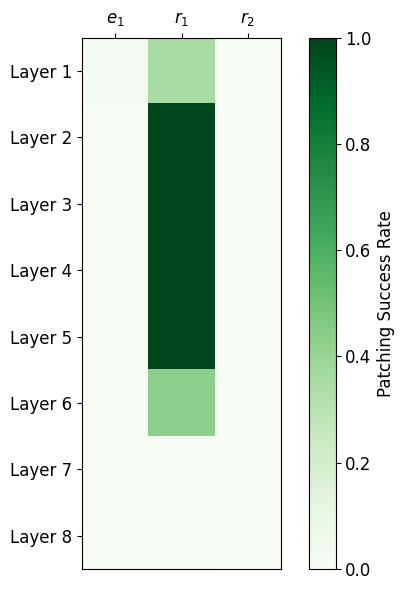

In [2]:
# draw the success_rate across layers and positions

import matplotlib.pyplot as plt
import numpy as np

data = success_rate

fig, ax = plt.subplots(figsize=(6, 6))

cmap = plt.cm.Greens.copy()
cmap.set_bad(color='white')

im = ax.imshow(data, cmap=cmap, vmin=0, vmax=1)

fontsize = 12

x_labels = ['$e_1$', '$r_1$', '$r_2$']
ax.set_xticks(np.arange(len(x_labels)))
ax.set_xticklabels(x_labels, fontsize=fontsize)
ax.xaxis.set_ticks_position('top')
ax.tick_params(top=True, labeltop=True)

y_labels = [f'Layer {i+1}' for i in range(data.shape[0])]
ax.set_yticks(np.arange(len(y_labels)))
ax.set_yticklabels(y_labels, fontsize=fontsize)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Patching Success Rate', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()
plt.show()
